In [ ]:
import os
!git clone https://github.com/aldo-fsm/fake-news-detection.git
os.chdir('fake-news-detection')
# !pip install pipfile-requirements
# !pipfile2req > requirements.txt
# !pip install -r requirements.txt
!pip install ktrain

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from IPython.display import display
import plotly_express as px
import plotly.io as pio
pio.renderers.default = 'colab'

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from preprocessing import stopwords, preprocess, putEndDot
from datasets import fake_br_corpus

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
dataset = fake_br_corpus.loadTrain(True)
dataset['text'] = dataset.text.apply(putEndDot)

In [ ]:
import ktrain
from ktrain import text

In [ ]:
dataset[['isFake', 'isTrue']] = dataset.label.apply(lambda label: pd.Series([1,0]) if label == 'fake' else pd.Series([0,1]))

In [ ]:
trn, val, preproc = text.texts_from_df(
  dataset,
  text_column='text',
  label_columns=['isFake', 'isTrue'], 
  maxlen=512, 
  preprocess_mode='bert',
)

['isFake', 'isTrue']
      isFake  isTrue
2511       0       1
5709       0       1
5805       0       1
2781       0       1
5169       0       1
['isFake', 'isTrue']
      isFake  isTrue
475        0       1
5383       0       1
2183       0       1
1589       0       1
2908       1       0
downloading pretrained BERT model (multi_cased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: pt


Is Multi-Label? False
preprocessing test...
language: pt


In [ ]:
model = text.text_classifier('bert', trn , preproc=preproc)

Is Multi-Label? False
maxlen is 512
done.


In [ ]:
learner = ktrain.get_learner(
  model, 
  train_data=trn, 
  val_data=val, 
  batch_size=6,
)

In [ ]:
learner.lr_find()

simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
914/914 [==============================] - 1419s 2s/step - loss: 0.6013 - accuracy: 0.6450
Epoch 2/1024
914/914 [==============================] - 620s 677ms/step - loss: 1.6925 - accuracy: 0.4965


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


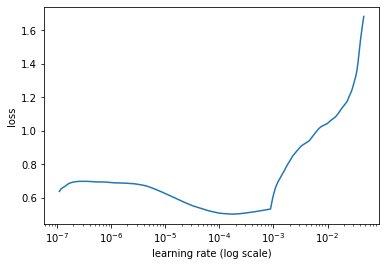

In [ ]:
learner.lr_plot()

In [ ]:
history = learner.fit_onecycle(2e-5, 1)



begin training using onecycle policy with max lr of 2e-05...
914/914 [==============================] - 1451s 2s/step - loss: 0.2000 - accuracy: 0.9097 - val_loss: 0.0320 - val_accuracy: 0.9885


In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [ ]:
model.save('model')

In [ ]:
predictor.save('predictor')

In [ ]:
!cp -r model ../drive/MyDrive/

In [ ]:
!cp -r predictor ../drive/MyDrive/

---

In [ ]:
history2 = learner.fit_onecycle(2e-5, 5)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/5
914/914 [==============================] - 1449s 2s/step - loss: 0.0336 - accuracy: 0.9885 - val_loss: 0.0618 - val_accuracy: 0.9803
Epoch 2/5
914/914 [==============================] - 1448s 2s/step - loss: 0.0320 - accuracy: 0.9892 - val_loss: 0.0393 - val_accuracy: 0.9869
Epoch 3/5
914/914 [==============================] - 1444s 2s/step - loss: 0.0413 - accuracy: 0.9860 - val_loss: 0.0301 - val_accuracy: 0.9902
Epoch 4/5
914/914 [==============================] - 1446s 2s/step - loss: 0.0128 - accuracy: 0.9958 - val_loss: 0.0184 - val_accuracy: 0.9934
Epoch 5/5
914/914 [==============================] - 1443s 2s/step - loss: 0.0025 - accuracy: 0.9993 - val_loss: 0.0228 - val_accuracy: 0.9934


In [ ]:
model.save('model2')
!cp -r model2 ../drive/MyDrive/

In [ ]:
predictor2 = ktrain.get_predictor(learner.model, preproc)

In [ ]:
ypred = evaluation.evaluate(predictor2, Xtest, ytrue)

              precision    recall  f1-score   support

      isFake       0.97      0.99      0.98       553
      isTrue       0.98      0.97      0.98       527

    accuracy                           0.98      1080
   macro avg       0.98      0.98      0.98      1080
weighted avg       0.98      0.98      0.98      1080

accuracy: 0.975925925925926


In [ ]:
predictor2.save('predictor2')
!cp -r predictor2 ../drive/MyDrive/

In [ ]:
history2.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr', 'iterations', 'momentum'])

In [ ]:
historyDf = pd.DataFrame(dict(
  loss=history2.history['loss'],
  accuracy=history2.history['accuracy'],
  val_loss=history2.history['val_loss'],
  val_accuracy=history2.history['val_accuracy'],
))

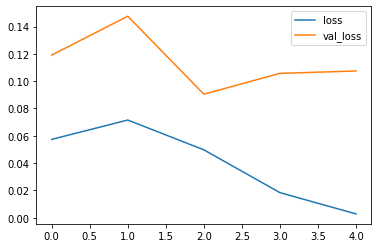

In [ ]:
historyDf[['loss', 'val_loss']].plot()

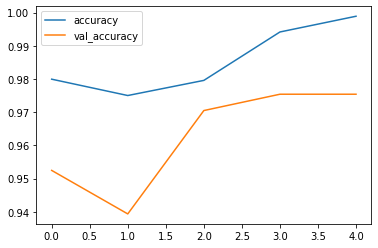

In [ ]:
historyDf[['accuracy', 'val_accuracy']].plot()

In [ ]:
from utils import evaluation

In [ ]:
evaluation.sizeDistributionByLabel(dataset.label, dataset.rankedText.apply(lambda text: len(text.split(' '))))

In [ ]:
predictor.predict(['''POLICIA Civil informa SE VOCÊ TIVER INFORTÚNIO DE SER VÍTIMA DE UM SEQÜESTRO-RELÂMPAGO, E TIVER QUE SACAR DINHEIRO NUM CAIXA ELETRÔNICO, MANTENHA A CALMA E TECLE SUA SENHA DE MANEIRA INVERSA'''])

['isFake']

In [ ]:
predictor.predict(['''POLICIA Civil informa SE VOCÊ TIVER INFORTÚNIO DE SER VÍTIMA DE UM SEQÜESTRO-RELÂMPAGO, E TIVER QUE SACAR DINHEIRO NUM CAIXA ELETRÔNICO, MANTENHA A CALMA E TECLE SUA SENHA DE MANEIRA INVERSA.'''])

['isTrue']

In [ ]:
dataset[dataset.label == 'fake'].rankedText.apply(lambda text: text.strip()[-1]).value_counts()

In [ ]:
dataset[dataset.label == 'true'].rankedText.apply(lambda text: text.strip()[-1]).value_counts()